In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2

In [3]:
from PIL import Image
import os
import random

def augment_images(input_directory, output_directory, num_copies=2):
    # Iterate through all subdirectories and their files
    for root, _, files in os.walk(input_directory):
        for image_file in files:
            # Join the directory path with the image file
            input_path = os.path.join(root, image_file)

            # Open the image using Pillow
            image = Image.open(input_path)

            # Generate augmented copies
            for i in range(num_copies):
                # Apply random transformations (you can customize these)
                rotated_image = image.rotate(random.uniform(-15, 15))
                flipped_image = rotated_image.transpose(Image.FLIP_LEFT_RIGHT)

                # Save the augmented image to the output directory
                relative_path = os.path.relpath(input_path, input_directory)
                output_filename = f'{os.path.splitext(relative_path)[0]}_{i}.png'
                output_path = os.path.join(output_directory, output_filename)

                # Create the subdirectories if they don't exist
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                flipped_image.save(output_path)

# Set the path to your main directory containing subdirectories
main_directory = '/kaggle/input/plants-dataset-sm/Plants_Dataset'
output_directory = '/kaggle/working/output/images'

# Call the function to augment images
augment_images(main_directory, output_directory)

In [4]:
train_data_dir="/kaggle/working/output/images"

In [5]:
image_size = (224,224)
batch_size = 4

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.20,
   
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set to 'training' for the training set
)

Found 3059 images belonging to 15 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set to 'validation' for the validation set
)

Found 757 images belonging to 15 classes.


In [ ]:
!zip -r dataset80.zip /kaggle/working/output/images
from IPython.display import FileLink
FileLink(r'dataset80.zip')

In [10]:
import tensorflow
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dropout
base_model = tensorflow.keras.applications.DenseNet201(weights='imagenet', include_top=False)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-5))(x) 
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(x)# Add L2 weight regularization
predictions = Dense(15, activation='softmax')(x)

In [11]:
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
model.compile(optimizer=Adam(learning_rate=7e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define learning rate schedule using ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,verbose=1,mode='min',start_from_epoch=15)

# Model Training
epochs = 50


H=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/50
764/764 [==============================] - 243s 159ms/step - loss: 1.3395 - accuracy: 0.6046 - val_loss: 1.1955 - val_accuracy: 0.7011 - lr: 7.0000e-05
Epoch 2/50
764/764 [==============================] - 115s 151ms/step - loss: 0.5770 - accuracy: 0.8337 - val_loss: 1.0616 - val_accuracy: 0.7288 - lr: 7.0000e-05
Epoch 3/50
764/764 [==============================] - 115s 150ms/step - loss: 0.4572 - accuracy: 0.8681 - val_loss: 1.2773 - val_accuracy: 0.7566 - lr: 7.0000e-05
Epoch 4/50
764/764 [==============================] - 115s 150ms/step - loss: 0.3623 - accuracy: 0.8975 - val_loss: 1.4114 - val_accuracy: 0.7447 - lr: 7.0000e-05
Epoch 5/50
764/764 [==============================] - 115s 151ms/step - loss: 0.3248 - accuracy: 0.9044 - val_loss: 1.1313 - val_accuracy: 0.8122 - lr: 7.0000e-05
Epoch 6/50
764/764 [==============================] - 115s 151ms/step - loss: 0.2607 - accuracy: 0.9264 - val_loss: 1.1627 - val_accuracy: 0.8188 - lr: 7.0000e-05
Epoch 7/50
764/764 [==

In [12]:
model.save('vedavision_densenetv5_sm.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
from IPython.display import FileLink
FileLink('vedavision_densenetv5_sm.h5')

/kaggle/working/vedavision_densenetv5_sm.h5

In [14]:
import zipfile
with zipfile.ZipFile('vedavision_densenetv5_sm.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('vedavision_densenetv5_sm.h5', 'vedavision_densenetv5_sm.h5')
FileLink('vedavision_densenetv5_sm.zip')

/kaggle/working/vedavision_densenetv5_sm.zip

In [15]:
import matplotlib.pyplot as plt

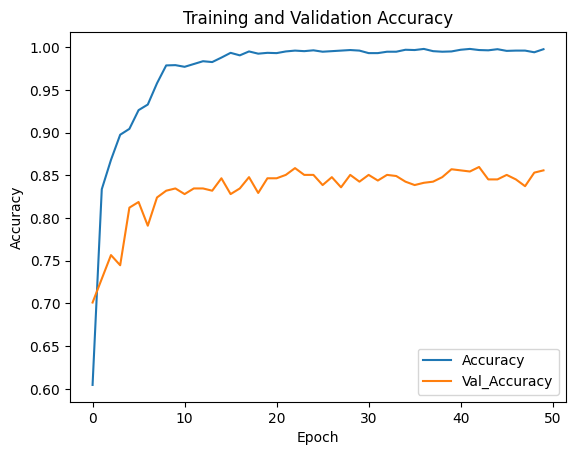

In [16]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val_Accuracy'])

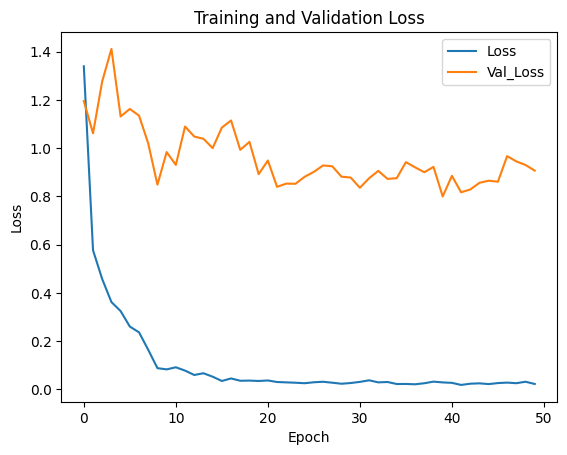

In [17]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])#get the accuracy for the training set from the model's history attribute
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val_Loss'])

In [47]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# Load your pre-trained TensorFlow model
model_path = '/kaggle/working/vedavision_densenetv5_sm.h5'
model = tf.keras.models.load_model(model_path)

# Define the image preprocessing function
def preprocess_image(image_path, target_size):
    response = requests.get(image_path)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values (assuming your model was trained with normalized data)
    return img_array

# URL of the downloaded image
image_url = "https://res.cloudinary.com/dxn2tkapb/image/upload/v1703020788/n1mddtl1tdziln7icbj3.jpg"
# Set the target image size to match your model's input size
input_size = (224,224)  # Adjust based on your model's input size
preprocessed_image = preprocess_image(image_url, target_size=input_size)
predictions = model.predict(preprocessed_image)
predicted_class_index = np.argmax(predictions)
directory_path="/kaggle/working/output/images"
class_labels = class_names = sorted(os.listdir(directory_path))
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print(f"Predicted Class: {predicted_class_label}")
max_index = np.argmax(predictions.flatten())

# Get the maximum value
max_value = predictions.flatten()[max_index]

# Print the result
print(f"Confidence: {max_value} ")

1/1 [==============================] - 3s 3s/step
Predicted Class: Shatavari
Confidence: 0.999995231628418 


In [20]:
predictions

array([[4.40055612e-16, 1.11526032e-17, 1.15684676e-16, 1.13482511e-18,
        2.66940079e-14, 7.11404168e-15, 2.04332934e-15, 3.66384666e-11,
        2.39151337e-13, 1.30767903e-14, 1.29832310e-16, 3.87001942e-16,
        1.06372541e-11, 1.00000000e+00, 8.12612863e-16, 6.41282080e-15,
        4.03317245e-13, 6.36453672e-13, 2.67643955e-19, 2.85837283e-12,
        6.11191046e-12, 1.01152469e-16, 8.01487710e-10, 4.27366470e-17,
        3.83245657e-11, 5.03646976e-14, 5.72120061e-15, 9.10813161e-11,
        4.78854898e-14, 6.04769878e-17, 8.27965300e-13, 1.74993781e-18,
        5.94089851e-15, 1.27150647e-18, 5.14638584e-14, 2.40673353e-20,
        2.81889194e-20, 7.88371548e-17, 2.35476417e-17, 4.43522254e-16,
        3.11922530e-15, 1.47511842e-12, 8.74852220e-14, 8.81701907e-18,
        3.06847585e-16, 5.15956554e-18, 6.33818790e-13, 7.13107721e-15,
        6.30697859e-13, 2.29409634e-12, 1.53298074e-18, 3.93033757e-14,
        3.22380310e-17, 1.09215566e-12, 6.92051498e-15, 5.733114

In [21]:
predicted_class_index

13

In [22]:
predicted_class_label

'Bilva'

In [23]:
class_labels

['Aloevera',
 'Amla',
 'Amruthaballi',
 'Arali',
 'Ashoka',
 'Ashwagandha',
 'Astma_weed',
 'Avacado',
 'Balloon Vine',
 'Bamboo',
 'Beans',
 'Betel',
 'Betel Nut',
 'Bilva',
 'Bitter melon',
 'Brhami',
 'Brhingraj',
 'Camphor',
 'Cardamom',
 'Caricature',
 'Castor',
 'Catharanthus',
 'Chikku',
 'Chilly',
 'Cinnamon',
 'Citron lime',
 'Coffee',
 'Common rue',
 'Coriender',
 'Cumin',
 'Curry Leaf',
 'Doddapatre',
 'Drumstick',
 'Ekka',
 'Eucalyptus',
 'Ganike',
 'Gasagase',
 'Geranium',
 'Ginger',
 'Globe Amarnath',
 'Gotu kola',
 'Guava',
 'Guggul',
 'Henna',
 'Hibiscus',
 'Honge',
 'Jackfruit',
 'Jamun',
 'Jasmine',
 'Jeevak',
 'Kakoli',
 'Kamakasturi',
 'Kambajala',
 'Kasamarda',
 'Kesar',
 'Kholrabi',
 'Lantana',
 'Lemangrass',
 'Lemon',
 'Licorice root',
 'Malabar Nut',
 'Malabar spinach',
 'Mango',
 'Marigold',
 'Meda',
 'Meswak',
 'Mint',
 'Neem',
 'Nelavembu',
 'Nooni',
 'Onion',
 'Palak',
 'Papaya',
 'Parijatha',
 'Pea',
 'Peepal',
 'Pepper',
 'Pomogranate',
 'Pumpkin',
 'Punar

In [26]:
pip install tensorflowjs

  Obtaining dependency information for packaging~=23.1 from https://files.pythonhosted.org/packages/ec/1a/610693ac4ee14fcdf2d9bf3c493370e4f2ef7ae2e19217d7a237ff42367d/packaging-23.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is 

In [33]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'/kaggle/working/modeljson')

In [34]:
import zipfile
with zipfile.ZipFile('densenetjsonv3.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('/kaggle/working/modeljson', '/kaggle/working/modeljson')
FileLink('densenetjsonv3.zip')

/kaggle/working/densenetjsonv3.zip

In [35]:
!zip -r densemodeljson.zip /kaggle/working/modeljson

  adding: kaggle/working/modeljson/ (stored 0%)
  adding: kaggle/working/modeljson/group1-shard13of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard15of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard7of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard2of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard17of20.bin (deflated 9%)
  adding: kaggle/working/modeljson/group1-shard19of20.bin (deflated 7%)
  adding: kaggle/working/modeljson/group1-shard8of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard11of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard12of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard18of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard10of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard5of20.bin (deflated 6%)
  adding: kaggle/working/modeljson/group1-shard1of20.bin (deflated 6%)
  adding: kaggle/work

In [36]:
from IPython.display import FileLink
FileLink(r'densemodeljson.zip')

/kaggle/working/densemodeljson.zip